<a href="https://colab.research.google.com/github/Kang-Yoonah/BigAi/blob/gh-pages/3/HandsOn/Chapter7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 7장. 앙상블 학습과 랜덤 포레스트

일련의 예측기(즉, 분류나 회귀 모델)로부터 예측을 수집하면 가장 좋은 모델 하나보다 더 좋은 예측을 얻을 수 있다.   
일련의 예측기를 **앙상블**이라고 부르기 때문에 이를 **앙상블 학습**이라고 하며, 앙상블 학습 알고리즘을 **앙상블 방법**이라고 한다.

예를 들어,   
훈련 세트로부터 무작위로 각기 다른 서브셋을 만들어 일련의 결정 트리 분류기를 훈련시킨다.   
예측 하기 위해선 모든 개별 트리의 예측을 구하여 가장 많은 선택을 받은 클래스를 예측으로 삼는다.   
이런 결정트리의 앙상블을 **랜덤 포레스트**라고 한다.

**배깅, 부스팅, 스태킹**과 같은 앙상블 방법이 있다.

## 설정

In [ ]:
import sys
assert sys.version_info >= (3, 5)

import sklearn
assert sklearn.__version__ >= "0.20"

import numpy as np
import os
import warnings
warnings.filterwarnings(action='ignore')

np.random.seed(42)

# 깔끔한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# 7.1 투표기반 분류기 (Voting 분류기)

**앙상블 밑바탕이 되는 생각**
- 각 분류기가 Weak Learner 약한 학습기일지라도 충분하게 많고 다양하다면 앙상블은 Strong Learner 강한 학습기가 될 수 있다.   
다시 말해서, 상대적으로 약한 여러 개의 학습기를 결합해 단일 분류기보다 신뢰성이 높은 예측값을 얻는 것을 목표로 한다.

**분류기 종류1**
- 보팅 Voting 분류기
    - 여러 개의 분류기가 투표를 통해 최종 예측 결과를 결정하는 방식
    - 같은 훈련 데이터에 대해 학습하고 예측한 결과를 투표하려 최종 예측 결과를 선정하는 방식이다.
    - Hard Voting 분류기
        - 각 분류기의 예측을 모아서 다수결 투표로 클래스를 예측하는 분류기
        - 이 다수결 투표 분류기가 앙상블에 포함된 개별 분류기 중 가장 뛰어난 것보다 정확도가 높을 경우가 많다.
    - Soft Voting 분류기
        - 각각의 분류기들의 클래스의 결정 확률을 모두 더하고 평균하여 가장 높은 클래스를 최종 보팅 결괏값으로 선정
        - 모든 분류기가 클래스의 확률을 추정할 수 있어야 한다.
        - 확률이 높은 투표에 비중을 더 두기 때문에 Hard Voting 방식보다 성능이 더 높다.
        - 일반적으로 더 많이 사용되는 방식이다.
    - 보팅을 한다고해서 항상 성능이 올라가진 않지만, 단일 ML 알고리즘보다 뛰어는 예측 성능을 가지는 경우가 많다.



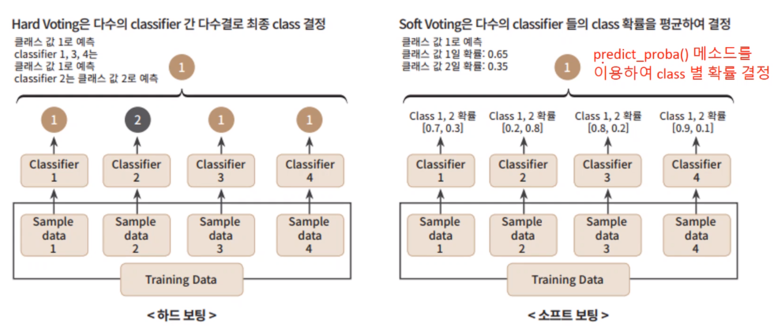

In [ ]:
from scipy.stats import binom

print('51% 정확도를 가진 1,000개의 분류기로 예측할 때의 정확도')
print(1 - binom.cdf(499,1000,0.51))
print()
print('10,000개의 분류기로 예측할 때의 정확도')
print(1 - binom.cdf(4999,10000,0.51))

51% 정확도를 가진 1,000개의 분류기로 예측할 때의 정확도
0.7467502275561786

10,000개의 분류기로 예측할 때의 정확도
0.9777976478701533


In [ ]:
heads_proba = 0.51
coin_tosses = (np.random.rand(10000, 10) < heads_proba).astype(np.int32)
cumulative_heads_ratio = np.cumsum(coin_tosses, axis=0) / np.arange(1, 10001).reshape(-1, 1)

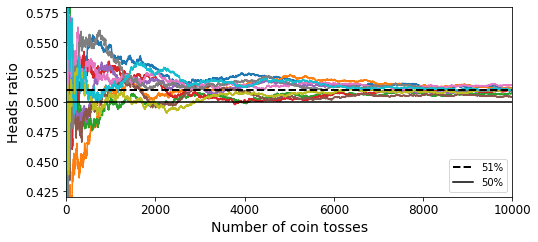

In [ ]:
plt.figure(figsize=(8,3.5))
plt.plot(cumulative_heads_ratio)
plt.plot([0, 10000], [0.51, 0.51], "k--", linewidth=2, label="51%")
plt.plot([0, 10000], [0.5, 0.5], "k-", label="50%")
plt.xlabel("Number of coin tosses")
plt.ylabel("Heads ratio")
plt.legend(loc="lower right")
plt.axis([0, 10000, 0.42, 0.58])

plt.show()

결과
- 큰 수의 법칙
    - 사건을 무한히 반복할 때 일정한 사건이 일어나는 비율은 횟수를 거듭하면 할수록 일정한 값에 가까워지는 법칙
- 동전을 던졌을 때 앞면이 51%, 뒷면이 49%가 나오는 균형이 맞지 않는 동전을 던진다고 가정하자.   
더 많이 던질수록 앞면이 나올 확률은 증가한다.   
즉, 계속해서 던질수록 앞면이 나오는 비율은 점점 더 앞면이 나올 확률(51%)에 가까워진다.
- 위의 그림은 균형이 틀어진 동전을 10번 실험한 그래프이다.   
10번의 실험 모두 50%보다 높게 유지되며 큰 수의 법칙에 의해 51%에 수렴하면서 끝나고 있다.   
 **따라서 앞면이 다수가 될 확률은 던지는 횟수를 거듭할 수록 높아진다.**

*moons 데이터셋을 사용하여 VotingClassifier 훈련하기 : Hard Voting*

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression(solver="lbfgs", random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
svm_clf = SVC(gamma="scale", random_state=42)

# VotingClassifier 모델
voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='hard')

In [ ]:
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svc', SVC(random_state=42))])

In [ ]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.912


**결과**
- 투표 기반 분류기가 다른 개별 분류기보다 성능이 더 높다.
- 앙상블 방법은 예측기가 가능한 한 서로 독립적일 때 최고의 성능을 발휘한다.   
다양한 분류기를 얻는 방법은 각기 다른 알고리즘으로 학습시키는 것이다.   
그럼 매우 다른 종류의 오차를 만들 가능성이 높기 때문에 앙상블 모델의 정확도를 향상시킨다.   
반면 분류기들이 서로 종속적이라면 같은 종류의 오차를 만들기 쉽기 때문에 잘못된 클래스가 다수인 경우가 많고 앙상블의 정확도가 낮아진다.

*VotingClassifier 훈련하기 : Soft Voting*

In [ ]:
log_clf = LogisticRegression(solver="lbfgs", random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
svm_clf = SVC(gamma="scale", probability=True, random_state=42)   # proba를 True로 변경해준다.

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='soft')
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svc', SVC(probability=True, random_state=42))],
                 voting='soft')

In [ ]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.92


# 7.2 배깅과 페이스팅

**분류기 종류2**
- 배깅 Bagging 분류기
    - 각각의 분류기가 모두 같은 유형의 알고리즘 기반이며, 데이터 샘플링을 서로 다르게 가져가면서 학습을 수행해 Voting을 수행하는 것이다.
    - 대표적으로 랜덤 포레스트가 있다.
    - **Bootstrap**
        - Train Data에서 여러 번 복원 추출하는 Random Sampling 기법(데이터 일부가 중첩됨)
            - 중복 허용하여 샘플링 : 배깅
            - 중복을 허용하지 않고 샘플링 : 페이스팅
            - 부트스트래핑은 각 예측기가 학습하는 서브셋에 다양성을 증가시키므로 배깅이 페이스팅보다 평향이 조금 더 높다.
                - 예측값들과 정답이 대체로 멀리 떨어져 있으면 결과의 편향이 높다.
                - 예측값들이 자기들끼리 대체로 멀리 흩어져 있으면 결과의 분산이 높다.
            - 하지만 다양성을 추가한다는 것은 예측기들의 상관관계를 줄이므로 앙상블의 분산을 감소시킨다. 
               - 전반적으로 배깅이 더 나은 모델을 만들기 때문에 일반적으로 더 선호한다. 
               - 시간과 CPU 파워에 여유가 있다면 교차 검증으로 배깅과 페이스팅을 모두 평가해서 선택하는 것이 좋다. 
        - 추출된 샘플들을 부트스트랩 샘플이라 부른다.
        - 이론적으로 36.8%의 샘플이 뽑히지 않게 된다. 이를 Out-Of-Bag 샘플이라고 한다.
        - Out-Of-Bag (OOB) 샘플의 사용
            - Test Data로서 사용할 수 있다.

- 모든 예측기가 훈련을 마치면 앙상블은 모든 예측기의 예측을 모아서 새로운 샘플에 대한 예측을 만든다.
- 수집 함수
   - 분류 : 통계적 최빈값(즉, 직접 투표 분류기처럼 가장 많은 예측 결과)
   - 회귀 : 평균을 계산한다.
- 개별 예측기는 원본 훈련 세트로 훈련시킨 것보다 훨씬 크게 편향되어 있지만(데이터가 적으므로)     
수집 함수를 통과하면 편향과 분산이 모두 감소한다. 
- 일반적으로는 앙상블의 결과는 원본 데이터셋으로 하나의 예측기를 훈련시킬때와 비교해 편향은 비슷하지만 분산은 줄어든다.



- 예측기는 모두 동시에 다른 CPU 코어나 서버에서 병렬로 학습시킬 수 있다.
- 이와 유사하게 예측도 병렬로 수행할 수 있다.

## 7.2.1 사이킷런의 배깅과 페이스팅

*BaggingClassifier 사용*

In [ ]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,    
    max_samples=100, bootstrap=True, random_state=42)
    # n_estimators=500 : 결정트리 분류기 500개의 앙상블    
    # max_samples=100, bootstrap=True : 각 분류기는 훈련세트에서 중복을 허용하여 무작위로 선택된 100개의 샘플로 훈련 
    # max_samples 매개변수는 0.0 ~ 1.0 사이의 실수로 지정할 수도 있다.(이렇게 하면 훈련세트의 비율로 할 수 있다.)
    # n_jobs 매개변수는 사이킷런이 훈련과 예측에 사용할 CPU 코어 수를 지정한다. (-1로 지정하면 가용한 모든 코어를 사용), 기본값은 1
    # BaggingClassifier는 기반이 되는 분류기가 결정 트리 분류기처럼 클래스 확률을 추정할 수 있으면(즉, predict_proba() 함수가 있으면)
    #    직접 투표 대신 자동으로 간접 투표 방식을 사용한다. 
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

In [ ]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, y_pred))

0.904


In [ ]:
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_test)
print(accuracy_score(y_test, y_pred_tree))

0.856


In [ ]:
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.45, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

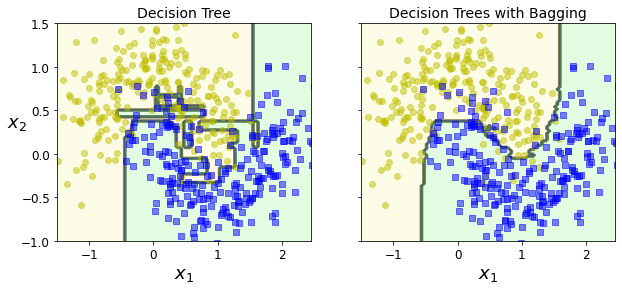

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(tree_clf, X, y)
plt.title("Decision Tree", fontsize=14)
plt.sca(axes[1])
plot_decision_boundary(bag_clf, X, y)
plt.title("Decision Trees with Bagging", fontsize=14)
plt.ylabel("")
plt.show()

- 결과
   - 앙상블의 예측이 결정 트리 하나의 예측보다 일반화가 잘 된다.
   - 앙상블은 비슷한 편향에서 더 작은 분산을 만든다.   
   (훈련세트의 오차 수가 거의 비슷하지만 결정 경계는 덜 불규칙하다.) 


## OOB 평가

- 배깅을 사용하면 어떤 샘플은 한 예측기를 위해 여러 번 샘플링되고 어떤 것은 전혀 선택되지 않을 수 있다.
- BaggingClassifier는 기본값으로 중복을 허용하여(bootstrap = True) 훈련 세트으 크기만큼인 m개 샘플을 선택한다. 
    - 이는 평균적으로 각 예측기에 훈련샘플의 63%(수학적인 계산) 정도만 샘플링된다는 것을 의미한다. 
    - 선택되지 않은 훈련 샘플 37% 를 **oob(out-of-bag) 샘플**이라고 부른다
       - 예측기마다 남겨진 37%는 모두 다르다.
- 예측기가 훈련되는 동안에는 oob 샘플을 사용하지 않으므로 별도의 검증 세트를 사용하지 않고 oob 샘플을 사용해 평가할 수 있다.
- 앙상블의 평가는 각 예측기의 oob 평가를 평균하여 얻는다. 
- 사이킷런에서 BaggingClassifier를 만들 때 oob_score = True로 지정하면 훈련이 끝난 후 자동으로 oob 평가를 수행한다.    

In [ ]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    bootstrap=True, oob_score=True, random_state=40)
bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

0.8986666666666666

In [ ]:
from sklearn.metrics import accuracy_score
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.912

- 결과 
    - oob 평가 점수와 테스트 세트의 정확도가 비슷하다 .

In [ ]:
# oob 샘플에 대한 결정 함수의 값도 확인 가능 
bag_clf.oob_decision_function_

array([[0.32275132, 0.67724868],
       [0.34117647, 0.65882353],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.        , 1.        ],
       [0.09497207, 0.90502793],
       [0.31147541, 0.68852459],
       [0.01754386, 0.98245614],
       [0.97109827, 0.02890173],
       [0.97765363, 0.02234637],
       [0.74404762, 0.25595238],
       [0.        , 1.        ],
       [0.7173913 , 0.2826087 ],
       [0.85026738, 0.14973262],
       [0.97222222, 0.02777778],
       [0.0625    , 0.9375    ],
       [0.        , 1.        ],
       [0.97837838, 0.02162162],
       [0.94642857, 0.05357143],
       [1.        , 0.        ],
       [0.01704545, 0.98295455],
       [0.39473684, 0.60526316],
       [0.88700565, 0.11299435],
       [1.        , 0.        ],
       [0.97790055, 0.02209945],
       [0.        , 1.        ],
       [0.99428571, 0.00571429],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.62569832, 0.37430168],
       [0.

# 7.3 랜덤 패치와 랜덤 서브스페이스

- BaggingClassifier는 특성 샘플링도 지원한다. 
    - 샘플링은 max_samples, bootstrap_features 두 매개변수로 조절된다. 
        - 작동 방식은 max_samples, bootstrap과 동일하지만 샘플이 아니고 특성에 대한 샘플링이다. 
        - 따라서 각 예측기는 무작위로 선택한 입력 특성의 일부분으로 훈련된다. 
- 이 기법은 특히 (이미지와 같은) 매우 고차원의 데이터셋을 다룰 때 유용하다.

- 랜덤 패치 방식 
    - 훈련 특성과 샘플을 모두 샘플링하는 것
- 랜덤 서브스페이스 방식
    - 훈련 샘플을 모두 사용하고(bootstrap = False이고 max_samples = 1.0로 설정)   
    특성은 샘플링하는(bootstrap_featurs = True 그리고/또는 max_features는 1.0보다 작게 설정) 

- 특성 샘플링은 더 다양한 예측기를 만들며 편향을 늘리는 대신 분산을 낮춘다. 

#7.4 랜덤 포레스트

- 랜덤포레스트
    - 일반적으로 배깅 방법(또는 페이스팅)을 적용한 결정 트리의 앙상블이다. 
    - 전형적으로 max_samples를 훈련 세트의 크기로 지정한다. 

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, random_state=42)
rnd_clf.fit(X_train, y_train)

y_pred_rf = rnd_clf.predict(X_test)

In [ ]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(max_features="sqrt", max_leaf_nodes=16),
    n_estimators=500, random_state=42)

In [ ]:
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

In [ ]:
np.sum(y_pred == y_pred_rf) / len(y_pred)  # 거의 에측이 동일합니다.

1.0

- RandomForestClassifier는 몇 가지 예외가 있지만 (트리 성장의 조절을 위한) Decision Tree Classifier의 매개변수와 앙상블 자체를 제어하는 데 필요한 BaggingClassifier의 매개변수를 모두 가지고 있다. 
- 랜덤 포레스트 알고리즘은 트리의 노드를 분할할 때 전체 특성 중에서 최선의 특성을 찾는 대신 무작위로 선택한 특성 후보 중에서 최적의 특성을 찾는 식으로 무작위성을 더 주입한다. 
    - 트리를 더욱 다양하게 만들고 (다시 한번) 편향을 손해보는 대신 분산을 낮추어 전체적으로 더 훌륭항 모델을 만든다. 

##7.4.1 엑스트라 트리

- 트리를 더욱 무작위하게 만들기 위해 (보통의 결정 트리처럼) 최적의 임곗값을 찾는 대신 후보 특성을 사용해 무작위로 분할한 다음 그중에서 최상의 분할을 선택한다. 
- 이와 같이 극단적으로 무작위한 트리의 맨덤 포레스트를 **익스트림 랜덤트리** 앙상블(또는 줄여서 **엑스트라 트리**)이라고 부른다. 
    - 편향이 늘어나지만 대신 분산을 낮춘다. 
    - 모든 노드에서 특성마다 가장 최적의 임곗값을 찾는 것이 트리 알고리즘에서 가장 시간이 많이 소요되는 작업 중 하나이므로 일반적인 랜덤 포레스트보다 엑스트라 트리가  
- 사이킷런의 ExtraTreesClassifier를 사용한다.
    - 사용법은 RandomForestClassifier과 같다. 
    - 마찬가지로 ExtraTreesRegressor도 RandomForestRegressor와 같은 API를 제공한다. 

##7.4.2 특성 중요도

**랜덤 포레스트의 장점2**
- 특성의 상대적 중요도를 측정하기 쉽다.
    - 사이킷런은 어떤 특성을 사용한 노드가 (랜덤포레스트에 있는 모든 트링 걸쳐서) 평균적으로 불순도를 얼마나 감소시키는지 확인하여 특성의 중요도를 측정 
    - 더 정확히 말하면 가중치 평균이며 각 노드의 가중치는 연관된 훈련 샘플 수와 같다. 
    - 사이킷런은 훈련이 끝난 뒤 특성마다 자동으로 이 점수를 계산하고 중요도의 전체 합이 1이 되도록 결괏갓을 정규화한다.
        - 이 값은 feature_importances_ 변수에 저장도어 있다.

In [ ]:
from sklearn.datasets import load_iris
iris = load_iris()
rnd_clf = RandomForestClassifier(n_estimators=500, random_state=42)
rnd_clf.fit(iris["data"], iris["target"])
for name, score in zip(iris["feature_names"], rnd_clf.feature_importances_):
    print(name, score)

sepal length (cm) 0.11249225099876375
sepal width (cm) 0.02311928828251033
petal length (cm) 0.4410304643639577
petal width (cm) 0.4233579963547682


In [ ]:
rnd_clf.feature_importances_

array([0.11249225, 0.02311929, 0.44103046, 0.423358  ])

*15개 결정 트리의 결정 경계 중첩한 그림*

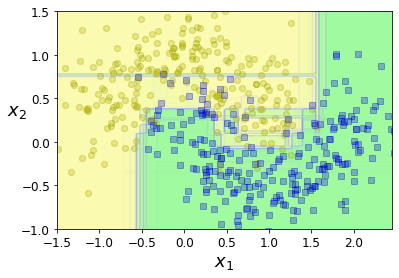

In [ ]:
plt.figure(figsize=(6, 4))

for i in range(15):
    tree_clf = DecisionTreeClassifier(max_leaf_nodes=16, random_state=42 + i)
    indices_with_replacement = np.random.randint(0, len(X_train), len(X_train))
    tree_clf.fit(X_train[indices_with_replacement], y_train[indices_with_replacement])
    plot_decision_boundary(tree_clf, X, y, axes=[-1.5, 2.45, -1, 1.5], alpha=0.02, contour=False)

plt.show()

**결과**
- 개별 결정 트리는 불완전하지만 앙상블되면 매우 좋은 결정 경계를 만든다.

*랜덤 포레스트 분류기에서 얻은 MNIST 픽셀 중요도*

In [ ]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1)
mnist.target = mnist.target.astype(np.uint8)

In [ ]:
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rnd_clf.fit(mnist["data"], mnist["target"])

RandomForestClassifier(random_state=42)

In [ ]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.hot,
               interpolation="nearest")
    plt.axis("off")

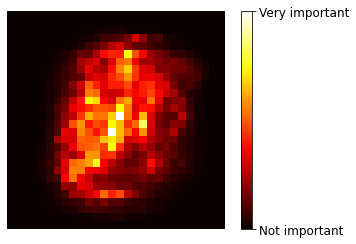

In [ ]:
plot_digit(rnd_clf.feature_importances_)

cbar = plt.colorbar(ticks=[rnd_clf.feature_importances_.min(), rnd_clf.feature_importances_.max()])
cbar.ax.set_yticklabels(['Not important', 'Very important'])
plt.show()

#7.5 부스팅

## 에이다부스트

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=200,
    algorithm="SAMME.R", learning_rate=0.5, random_state=42)
ada_clf.fit(X_train, y_train)

In [ ]:
plot_decision_boundary(ada_clf, X, y)

**<그림 7-8. 연속된 예측기의 결정 경계> 생성 코드**

In [ ]:
m = len(X_train)

fig, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)
for subplot, learning_rate in ((0, 1), (1, 0.5)):
    sample_weights = np.ones(m) / m
    plt.sca(axes[subplot])
    for i in range(5):
        svm_clf = SVC(kernel="rbf", C=0.2, gamma=0.6, random_state=42)
        svm_clf.fit(X_train, y_train, sample_weight=sample_weights * m)
        y_pred = svm_clf.predict(X_train)
        r = sample_weights[y_pred != y_train].sum() / sample_weights.sum() # equation 7-1
        alpha = learning_rate * np.log((1 - r) / r) # equation 7-2
        sample_weights[y_pred != y_train] *= np.exp(alpha) # equation 7-3
        sample_weights /= sample_weights.sum() # normalization step
        plot_decision_boundary(svm_clf, X, y, alpha=0.2)
        plt.title("learning_rate = {}".format(learning_rate), fontsize=16)
    if subplot == 0:
        plt.text(-0.7, -0.65, "1", fontsize=14)
        plt.text(-0.6, -0.10, "2", fontsize=14)
        plt.text(-0.5,  0.10, "3", fontsize=14)
        plt.text(-0.4,  0.55, "4", fontsize=14)
        plt.text(-0.3,  0.90, "5", fontsize=14)
    else:
        plt.ylabel("")

save_fig("boosting_plot")
plt.show()

# 그레이디언트 부스팅

간단한 이차식 형태의 데이터셋을 만들어 보죠:

In [ ]:
np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3*X[:, 0]**2 + 0.05 * np.random.randn(100)

이제 이 데이터셋에 결정 트리 회귀 모델을 훈련시킵니다:

In [ ]:
from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg1.fit(X, y)

In [ ]:
y2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg2.fit(X, y2)

In [ ]:
y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg3.fit(X, y3)

In [ ]:
X_new = np.array([[0.8]])

In [ ]:
y_pred = sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))

In [ ]:
y_pred

**<그림 7-9> 생성 코드**

In [ ]:
def plot_predictions(regressors, X, y, axes, label=None, style="r-", data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1)) for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center", fontsize=16)
    plt.axis(axes)

In [ ]:
plt.figure(figsize=(11,11))

plt.subplot(321)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h_1(x_1)$", style="g-", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Residuals and tree predictions", fontsize=16)

plt.subplot(322)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1)$", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Ensemble predictions", fontsize=16)

plt.subplot(323)
plot_predictions([tree_reg2], X, y2, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_2(x_1)$", style="g-", data_style="k+", data_label="Residuals")
plt.ylabel("$y - h_1(x_1)$", fontsize=16)

plt.subplot(324)
plot_predictions([tree_reg1, tree_reg2], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1)$")
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.subplot(325)
plot_predictions([tree_reg3], X, y3, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_3(x_1)$", style="g-", data_style="k+")
plt.ylabel("$y - h_1(x_1) - h_2(x_1)$", fontsize=16)
plt.xlabel("$x_1$", fontsize=16)

plt.subplot(326)
plot_predictions([tree_reg1, tree_reg2, tree_reg3], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1) + h_3(x_1)$")
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

save_fig("gradient_boosting_plot")
plt.show()

이제 그레이디언트 부스팅 회귀 모델을 사용해 보죠:

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1.0, random_state=42)
gbrt.fit(X, y)

**<그림 7-10. 예측기가 부족한 경우(왼쪽)과 너무 많은 경우(오른쪽)의 GBRT 앙상블> 생성 코드**

In [ ]:
gbrt_slow = GradientBoostingRegressor(max_depth=2, n_estimators=200, learning_rate=0.1, random_state=42)
gbrt_slow.fit(X, y)

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)

plt.sca(axes[0])
plot_predictions([gbrt], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="Ensemble predictions")
plt.title("learning_rate={}, n_estimators={}".format(gbrt.learning_rate, gbrt.n_estimators), fontsize=14)
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.sca(axes[1])
plot_predictions([gbrt_slow], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("learning_rate={}, n_estimators={}".format(gbrt_slow.learning_rate, gbrt_slow.n_estimators), fontsize=14)
plt.xlabel("$x_1$", fontsize=16)

save_fig("gbrt_learning_rate_plot")
plt.show()

**조기 종료를 사용한 그래디언트 부스팅**

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=49)

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=120, random_state=42)
gbrt.fit(X_train, y_train)

errors = [mean_squared_error(y_val, y_pred)
          for y_pred in gbrt.staged_predict(X_val)]
bst_n_estimators = np.argmin(errors) + 1

gbrt_best = GradientBoostingRegressor(max_depth=2, n_estimators=bst_n_estimators, random_state=42)
gbrt_best.fit(X_train, y_train)

**<그림 7-11. 조기 종료를 사용하여 트리 수 튜닝> 생성 코드**

In [ ]:
min_error = np.min(errors)

In [ ]:
plt.figure(figsize=(10, 4))

plt.subplot(121)
plt.plot(np.arange(1, len(errors) + 1), errors, "b.-")
plt.plot([bst_n_estimators, bst_n_estimators], [0, min_error], "k--")
plt.plot([0, 120], [min_error, min_error], "k--")
plt.plot(bst_n_estimators, min_error, "ko")
plt.text(bst_n_estimators, min_error*1.2, "Minimum", ha="center", fontsize=14)
plt.axis([0, 120, 0, 0.01])
plt.xlabel("Number of trees")
plt.ylabel("Error", fontsize=16)
plt.title("Validation error", fontsize=14)

plt.subplot(122)
plot_predictions([gbrt_best], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("Best model (%d trees)" % bst_n_estimators, fontsize=14)
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.xlabel("$x_1$", fontsize=16)

save_fig("early_stopping_gbrt_plot")
plt.show()

어느 정도 유예를 갖는 조기 종료(5 에포크 동안 향상되지 않을 때만 훈련 중지):

In [ ]:
gbrt = GradientBoostingRegressor(max_depth=2, warm_start=True, random_state=42)

min_val_error = float("inf")
error_going_up = 0
for n_estimators in range(1, 120):
    gbrt.n_estimators = n_estimators
    gbrt.fit(X_train, y_train)
    y_pred = gbrt.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)
    if val_error < min_val_error:
        min_val_error = val_error
        error_going_up = 0
    else:
        error_going_up += 1
        if error_going_up == 5:
            break  # early stopping

In [ ]:
print(gbrt.n_estimators)

In [ ]:
print("Minimum validation MSE:", min_val_error)

**XGBoost 사용하기**

In [ ]:
try:
    import xgboost
except ImportError as ex:
    print("에러: xgboost 라이브러리 설치되지 않았습니다.")
    xgboost = None

In [ ]:
if xgboost is not None:  # 책에 없음
    xgb_reg = xgboost.XGBRegressor(random_state=42)
    xgb_reg.fit(X_train, y_train)
    y_pred = xgb_reg.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred) # 책에 없음
    print("Validation MSE:", val_error)           # 책에 없음

In [ ]:
if xgboost is not None:  # 책에 없음
    xgb_reg.fit(X_train, y_train,
                eval_set=[(X_val, y_val)], early_stopping_rounds=2)
    y_pred = xgb_reg.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)  # 책에 없음
    print("Validation MSE:", val_error)            # 책에 없음

In [ ]:
%timeit xgboost.XGBRegressor().fit(X_train, y_train) if xgboost is not None else None

In [ ]:
%timeit GradientBoostingRegressor().fit(X_train, y_train)

# 연습문제 해답

## 1. to 7.

부록 A 참조.

## 8. 투표 기반 분류기

문제: _MNIST 데이터를 불러들여 훈련 세트, 검증 세트, 테스트 세트로 나눕니다(예를 들면 훈련에 40,000개 샘플, 검증에 10,000개 샘플, 테스트에 10,000개 샘플)._

MNIST 데이터셋은 앞에서 로드했습니다.

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train_val, X_test, y_train_val, y_test = train_test_split(
    mnist.data, mnist.target, test_size=10000, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=10000, random_state=42)

문제: _그런 다음 랜덤 포레스트 분류기, 엑스트라 트리 분류기, SVM 같은 여러 종류의 분류기를 훈련시킵니다._

In [ ]:
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier

In [ ]:
random_forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
extra_trees_clf = ExtraTreesClassifier(n_estimators=100, random_state=42)
svm_clf = LinearSVC(max_iter=100, tol=20, random_state=42)
mlp_clf = MLPClassifier(random_state=42)

In [ ]:
estimators = [random_forest_clf, extra_trees_clf, svm_clf, mlp_clf]
for estimator in estimators:
    print("Training the", estimator)
    estimator.fit(X_train, y_train)

In [ ]:
[estimator.score(X_val, y_val) for estimator in estimators]

선형 SVM이 다른 분류기보다 성능이 많이 떨어집니다. 그러나 투표 기반 분류기의 성능을 향상시킬 수 있으므로 그대로 두겠습니다.

문제: _그리고 검증 세트에서 개개의 분류기보다 더 높은 성능을 내도록 이들을 간접 또는 직접 투표 분류기를 사용하는 앙상블로 연결해보세요._

In [ ]:
from sklearn.ensemble import VotingClassifier

In [ ]:
named_estimators = [
    ("random_forest_clf", random_forest_clf),
    ("extra_trees_clf", extra_trees_clf),
    ("svm_clf", svm_clf),
    ("mlp_clf", mlp_clf),
]

In [ ]:
voting_clf = VotingClassifier(named_estimators)

In [ ]:
voting_clf.fit(X_train, y_train)

In [ ]:
voting_clf.score(X_val, y_val)

In [ ]:
[estimator.score(X_val, y_val) for estimator in voting_clf.estimators_]

SVM 모델을 제거해서 성능이 향상되는지 확인해 보죠. 다음과 같이 `set_params()`를 사용하여 `None`으로 지정하면 특정 예측기를  제외시킬 수 있습니다:

In [ ]:
voting_clf.set_params(svm_clf=None)

예측기 목록이 업데이트되었습니다:

In [ ]:
voting_clf.estimators

하지만 훈련된 예측기 목록은 업데이트되지 않습니다:

In [ ]:
voting_clf.estimators_

`VotingClassifier`를 다시 훈련시키거나 그냥 훈련된 예측기 목록에서 SVM 모델을 제거할 수 있습니다:

In [ ]:
del voting_clf.estimators_[2]

`VotingClassifier`를 다시 평가해 보죠:

In [ ]:
voting_clf.score(X_val, y_val)

훨씬 나아졌네요! SVM 모델이 성능을 저하시켰습니다. 이제 간접 투표 분류기를 사용해 보죠. 분류기를 다시 훈련시킬 필요는 없고 `voting`을 `"soft"`로 지정하면 됩니다:

In [ ]:
voting_clf.voting = "soft"

In [ ]:
voting_clf.score(X_val, y_val)

이 경우는 직접 투표 방식이 낫네요.

_앙상블을 얻고 나면 테스트 세트로 확인해보세요. 개개의 분류기와 비교해서 성능이 얼마나 향상되나요?_

In [ ]:
voting_clf.voting = "hard"
voting_clf.score(X_test, y_test)

In [ ]:
[estimator.score(X_test, y_test) for estimator in voting_clf.estimators_]

여기서는 투표 기반 분류기가 최선의 모델의 오차율을 아주 조금만 감소시킵니다.

## 9. 스태킹 앙상블

문제: _이전 연습문제의 각 분류기를 실행해서 검증 세트에서 예측을 만들고 그 결과로 새로운 훈련 세트를 만들어보세요. 각 훈련 샘플은 하나의 이미지에 대한 전체 분류기의 예측을 담은 벡터고 타깃은 이미지의 클래스입니다. 새로운 훈련 세트에 분류기 하나를 훈련시켜 보세요._

In [ ]:
X_val_predictions = np.empty((len(X_val), len(estimators)), dtype=np.float32)

for index, estimator in enumerate(estimators):
    X_val_predictions[:, index] = estimator.predict(X_val)

In [ ]:
X_val_predictions

In [ ]:
rnd_forest_blender = RandomForestClassifier(n_estimators=200, oob_score=True, random_state=42)
rnd_forest_blender.fit(X_val_predictions, y_val)

In [ ]:
rnd_forest_blender.oob_score_

이 블렌더를 세밀하게 튜닝하거나 다른 종류의 블렌더(예를 들어, `MLPClassifier`)를 시도해 볼 수 있습니다. 그런 늘 하던대로 다음 교차 검증을 사용해 가장 좋은 것을 선택합니다.

문제: _축하합니다. 방금 블렌더를 훈련시켰습니다. 그리고 이 분류기를 모아서 스태킹 앙상블을 구성했습니다. 이제 테스트 세트에 앙상블을 평가해보세요. 테스트 세트의 각 이미지에 대해 모든 분류기로 예측을 만들고 앙상블의 예측 결과를 만들기 위해 블렌더에 그 예측을 주입합니다. 앞서 만든 투표 분류기와 비교하면 어떤가요?_

In [ ]:
X_test_predictions = np.empty((len(X_test), len(estimators)), dtype=np.float32)

for index, estimator in enumerate(estimators):
    X_test_predictions[:, index] = estimator.predict(X_test)

In [ ]:
y_pred = rnd_forest_blender.predict(X_test_predictions)

In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
accuracy_score(y_test, y_pred)

이 스태킹 앙상블은 앞서 만든 투표 기반 분류기만큼 성능을 내지는 못합니다. 최선의 개별 분류기만큼 뛰어나지는 않습니다.